In [1]:
from zs6d import ZS6D
import os
import json


# Loading the config file:
with open(os.path.join("./zs6d_configs/bop_eval_configs/cfg_ycbv_inference_bop.json"), "r") as f:
    config = json.load(f)

# TODO: Fix Groundtruths -> 642 instead of 341 templates

# Instantiating the pose estimator:
# This involves handing over the path to the templates_gt file and the corresponding object norm_factors.
pose_estimator = ZS6D(config['templates_gt_path'], config['norm_factor_path'])

device=cuda


Using cache found in C:\Users\Shype/.cache\torch\hub\facebookresearch_dino_main
100%|██████████| 21/21 [00:41<00:00,  1.98s/it]


Matches Template: 119
R_est: [[ 0.9182122   0.39603306 -0.00664614]
 [-0.1378493   0.3037865  -0.94271487]
 [-0.37132725  0.86652846  0.33353335]]
t_est: [-36.07452182 -84.63827372 908.15832295]
R_ref: False
t_ref: False
R_gt: [[ 0.93764381  0.036429   -0.34568524]
 [-0.17290696  0.91160753 -0.3729277 ]
 [ 0.30154368  0.40944491  0.86106102]]
t_gt: [-39.29863396 -88.86722349 895.89554816]
Init (45.30395691195857, 0.0)
Ref (90.0, 0.0)


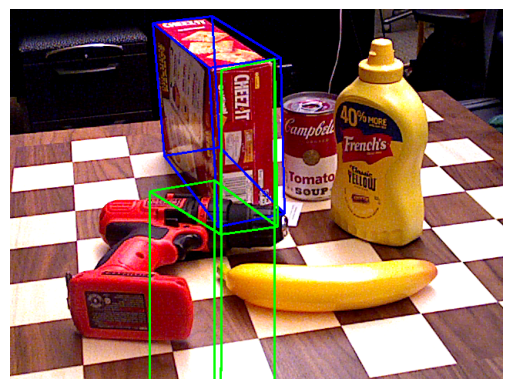

Matches Template: 320
R_est: [[-0.99995764 -0.00493862  0.00776752]
 [-0.00857092  0.1918906  -0.9813789 ]
 [ 0.00335615 -0.9814039  -0.1919248 ]]
t_est: [ 67.45887417 -52.74438415 995.67464015]
R_ref: False
t_ref: False
R_gt: [[-0.9886917  -0.13617697 -0.06280829]
 [ 0.0046778   0.39061499 -0.92054252]
 [ 0.1498914  -0.9104262  -0.38556111]]
t_gt: [ 66.65276382 -50.99970962 863.88090072]
Init (11.685983757004552, 1.0)
Ref (90.0, 0.0)


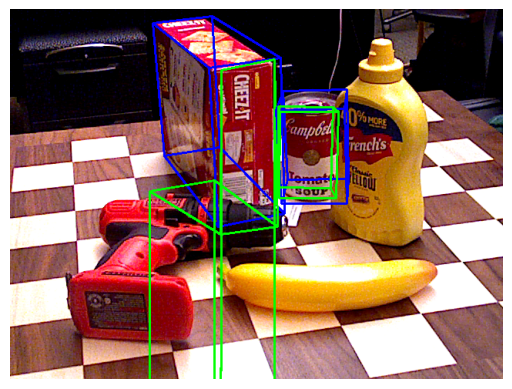

Matches Template: 327
R_est: [[-0.97057333 -0.211639    0.11487533]
 [-0.15034904  0.159949   -0.97560826]
 [ 0.18810257 -0.96417076 -0.18706195]]
t_est: [124.87647283 -50.34280569 773.20117657]
R_ref: False
t_ref: False
R_gt: [[-0.93026471 -0.36460736 -0.0408465 ]
 [-0.11548155  0.39666335 -0.91067151]
 [ 0.34824001 -0.84244845 -0.41110798]]
t_gt: [117.83860159 -49.99487533 765.23623131]
Init (14.767788029053781, 1.0)
Ref (90.0, 0.0)


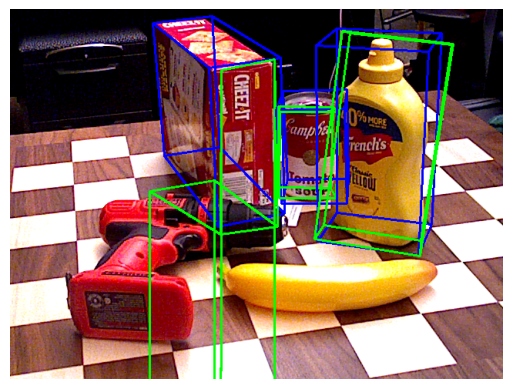

Matches Template: 163
R_est: [[ 0.46838051  0.87911074 -0.08822703]
 [-0.54777016  0.21058567 -0.80969224]
 [-0.6932298   0.4275722   0.58018485]]
t_est: [ 70.27639005  88.46155252 773.29577131]
R_ref: False
t_ref: False
R_gt: [[-0.31018047 -0.94946964 -0.04790576]
 [-0.43053532  0.18522114 -0.88336428]
 [ 0.84760134 -0.25337655 -0.46623254]]
t_gt: [ 66.72758612  61.64748115 707.72736348]
Init (113.51225018481432, 0.0)
Ref (90.0, 0.0)


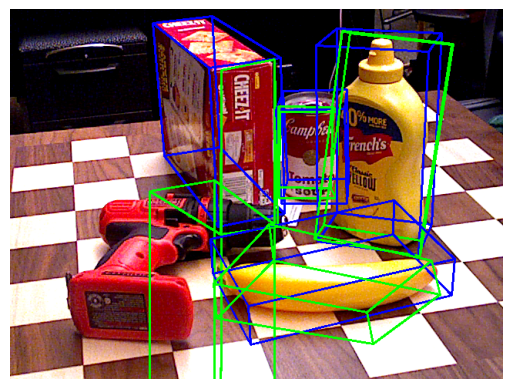

Matches Template: 146
R_est: [[-0.97458369  0.21953823  0.044605  ]
 [-0.11679089 -0.3279994  -0.93743068]
 [-0.19117146 -0.91881411  0.34530293]]
t_est: [-75.65121405  31.90824922 720.73167617]
R_ref: False
t_ref: False
R_gt: [[-0.97571082  0.19871648  0.0921985 ]
 [ 0.00429079 -0.40346093  0.91498724]
 [ 0.21902116  0.89315814  0.39280889]]
t_gt: [-63.04554351  54.29427143 716.94331732]
Init (92.04895341203174, 0.0)
Ref (90.0, 0.0)


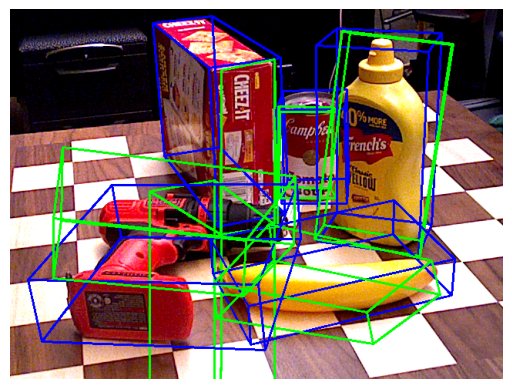

In [4]:
import cv2
from PIL import Image
import pose_utils.img_utils as img_utils
import pose_utils.vis_utils as vis_utils
import pose_utils.eval_utils as eval_utils
import numpy as np
import time
import matplotlib.pyplot as plt
import copy

# Loading a ground truth file to access segmentation masks to test zs6d:
with open(os.path.join(config['gt_path']), 'r') as f:
    data_gt = json.load(f)

img_id = '000050_1756' #'000050_1778'
scene = img_id.split('_')[0]
img_nr = "{img:06}".format(img=int(img_id.split('_')[1]))  

# Open Ground Truth for BB
path = f"./test/{scene}/scene_gt.json"
with open(path, 'r') as f:
        bb_gt = json.load(f)

rgb_img_gt = np.array(Image.open(f"test/{img_id.split('_')[0]}/rgb/{img_nr}.png"))
rgb_img_gt_ref = np.array(Image.open(f"test/{img_id.split('_')[0]}/rgb/{img_nr}.png"))

for i in range(len(data_gt[img_id])):
    obj_number = i  # Gets the i-th object in the image
    obj_id = data_gt[img_id][obj_number]['obj_id']      # Gets the corresponding object_id for the current object
    cam_K = np.array(data_gt[img_id][obj_number]['cam_K']).reshape((3,3))
    bbox = data_gt[img_id][obj_number]['bbox_visib']    # Gets the Bounding Box Parameters for the current object
    img_path = f"test/{scene}/rgb/{img_nr}.png"  #"test/000048/rgb/000001.png"
    #os.path.join(config['dataset_path'], data_gt[img_id][obj_number]['img_name'].split("./")[-1])
    img = Image.open(img_path)  
    img_temp = copy.deepcopy(img)

    mask = data_gt[img_id][obj_number]['mask_sam']
    mask = img_utils.rle_to_mask(mask)
    mask = mask.astype(np.uint8)
    
    # To estimate the objects Rotation R and translation t the input image, the object_id, a segmentation mask and camera matrix are necessary
    R_est, t_est, R_ref, t_ref = pose_estimator.get_pose(img_temp, str(obj_id), mask, cam_K, num_comp=100, bbox=None)
    
    print(f"R_est: {R_est}")
    print(f"t_est: {t_est}")
    print(f"R_ref: {R_ref}")
    print(f"t_ref: {t_ref}")
    obj_gt_bb = bb_gt[img_id.split('_')[-1]][obj_number]
    print(f"R_gt: {np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3))}")
    print(f"t_gt: {np.array(obj_gt_bb['cam_t_m2c'])}")
    
    # Add Ground Truth BB
    rgb_img_gt = vis_utils.draw_3D_bbox_on_image(np.array(rgb_img_gt), np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), np.array(obj_gt_bb['cam_t_m2c']), cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=(0,0,255))
    
    rgb_img_gt_ref = vis_utils.draw_3D_bbox_on_image(np.array(rgb_img_gt_ref), np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), np.array(obj_gt_bb['cam_t_m2c']), cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=(0,0,255))
    
    #plt.axis('off')
    #plt.imshow(rgb_img_gt)
    #plt.show()
    
    # Mark Very Wrong guesses in RED
    #colEst1 = (255, 0, 0) if eval_utils.calculate_score(R_est, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id)[1] == 0 else (0, 255, 0)
    #colEst2 = (255, 0, 0) if eval_utils.calculate_score(R_ref, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id)[1] == 0 else (0, 255, 0)
    
    colEst1 = (0,255,0)
    colEst2 = (0,255,0)
 
    print("Init",eval_utils.calculate_score(R_est, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id))
    print("Ref",eval_utils.calculate_score(R_ref, np.array(obj_gt_bb['cam_R_m2c']).reshape((3,3)), obj_id))
    
    # Add Initial BB
    rgb_img_gt = vis_utils.draw_3D_bbox_on_image(rgb_img_gt, R_est, t_est, cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=colEst1)
    
    plt.axis('off')
    plt.imshow(rgb_img_gt)
    plt.show()
    
    # Add Refined BB
    #rgb_img_gt_ref = vis_utils.draw_3D_bbox_on_image(rgb_img_gt_ref, R_ref, t_ref, cam_K, data_gt[img_id][obj_number]['model_info'], factor=1, colEst=colEst2)

    #plt.axis('off')
    #plt.imshow(rgb_img_gt_ref)
    #plt.show()
